In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import os
Root = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification"
os.chdir(Root)

[Dataset](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification)

In [45]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
audio_dataset_path='/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/Data/genres_original'
metadata=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


**Feature Extractor Function**

Mel Frequency Cepstral Coefficients:

These are state-of-the-art features used in automatic speech and speech recognition studies. There are a set of steps for generation of these features:

Since the audio signals are constantly changing, first we divide these signals into smaller frames. Each frame is around 20-40 ms long
Then we try to identify different frequencies present in each frame
Now, separate linguistic frequencies from the noise
To discard the noise, it then takes discrete cosine transform (DCT) of these frequencies. Using DCT we keep only a specific sequence of frequencies that have a high probability of information.

In [47]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [48]:
# metadata.drop(labels=552, axis=0, inplace=True)

In [49]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row["label"]
        file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"]))    
        data=features_extractor(file_name)
        extracted_features.append([data,final_class_labels])
    except Exception as e:
        print(f"Error: {e}")
        continue

554it [00:53, 10.67it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
557it [00:53,  8.12it/s]

Error: 


1000it [01:36, 10.39it/s]


In [50]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-113.57065, 121.57179, -19.168142, 42.36642, ...",blues
1,"[-207.5017, 123.991264, 8.955127, 35.87765, 2....",blues
2,"[-90.722595, 140.4463, -29.09389, 31.684334, -...",blues
3,"[-199.5442, 150.09091, 5.6626782, 26.85908, 1....",blues
4,"[-160.3377, 126.219635, -35.58781, 22.148071, ...",blues


In [51]:
extracted_features_df['class'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: class, dtype: int64

**Split the dataset into independent and dependent dataset**

In [52]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [53]:
X.shape

(999, 40)

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [55]:
y.shape

(999, 10)

**Train Test Split**

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [57]:
X_train

array([[ 2.67117920e+01,  7.97894287e+01, -5.20517769e+01, ...,
        -1.43984926e+00, -1.27259743e+00, -5.90781355e+00],
       [-1.44929214e+02,  1.18459854e+02,  2.05253220e+01, ...,
         1.89384019e+00, -1.88978815e+00, -1.85136843e+00],
       [-6.60630646e+01,  9.78820724e+01, -1.88321342e+01, ...,
        -1.23837304e+00, -6.33012116e-01, -1.33665276e+00],
       ...,
       [-7.74571762e+01,  1.30936478e+02, -2.33290615e+01, ...,
        -4.20865250e+00, -3.52202845e+00,  2.60719037e+00],
       [-1.90423065e+02,  1.29542053e+02, -7.84552956e+00, ...,
        -2.24016356e+00, -3.98439646e+00, -1.98053861e+00],
       [-4.65721245e+01,  8.68102798e+01, -3.47887421e+01, ...,
         1.48847297e-01,  9.24574316e-01, -8.69751930e-01]], dtype=float32)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(799, 40)
(200, 40)
(799, 10)
(200, 10)


In [59]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [61]:
### No of classes
num_labels=y.shape[1]

In [62]:
y.shape[1]

10

In [63]:
model=Sequential()
model.add(Dense(1024,input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels, activation="softmax"))

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              41984     
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [65]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [66]:
import time
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

In [67]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=f'saved_models/audio_classification_{current_time}.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
24/25 [===========================>..] - ETA: 0s - loss: 4.3648 - accuracy: 0.1146
Epoch 1: val_loss improved from inf to 2.34635, saving model to saved_models/audio_classification_03:12:42.hdf5
25/25 [==============================] - 2s 31ms/step - loss: 4.2931 - accuracy: 0.1164 - val_loss: 2.3463 - val_accuracy: 0.0400
Epoch 2/100
24/25 [===========================>..] - ETA: 0s - loss: 2.6907 - accuracy: 0.1198
Epoch 2: val_loss improved from 2.34635 to 2.28599, saving model to saved_models/audio_classification_03:12:42.hdf5
25/25 [==============================] - 1s 25ms/step - loss: 2.6802 - accuracy: 0.1189 - val_loss: 2.2860 - val_accuracy: 0.1400
Epoch 3/100
23/25 [==========================>...] - ETA: 0s - loss: 2.4361 - accuracy: 0.1345
Epoch 3: val_loss improved from 2.28599 to 2.25691, saving model to saved_models/audio_classification_03:12:42.hdf5
25/25 [==============================] - 0s 18ms/step - loss: 2.4250 - accuracy: 0.1352 - val_loss: 2.2569 - va

In [68]:
model.evaluate(X_test,y_test,verbose=0)

[1.7503818273544312, 0.6449999809265137]

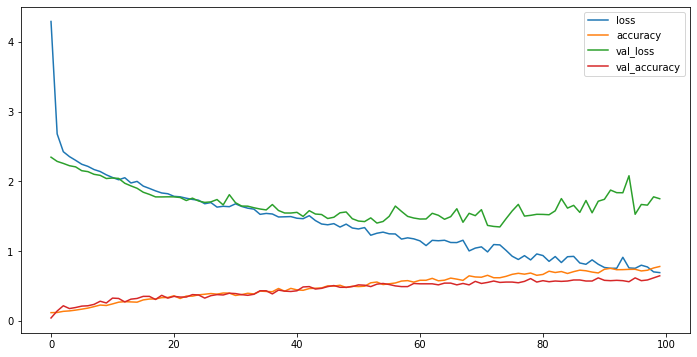

In [69]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [71]:
model.predict_classes(x_test)

AttributeError: ignored

In [72]:
filename="/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/Data/genres_original/disco/disco.00008.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-3.25368500e+01  6.50393219e+01 -2.67630997e+01  3.02974186e+01
  5.69683838e+00  1.16638546e+01 -2.22349167e+00  1.04245052e+01
 -2.37087750e+00  5.36994505e+00 -3.87637377e+00 -8.61713052e-01
 -2.10004076e-01  3.47398019e+00 -3.05001831e+00  3.60353827e-01
 -9.34530258e-01  1.18293035e+00  2.21510623e-02  2.92843318e+00
  3.44137371e-01  6.35234833e-01 -2.26225734e+00 -1.13395762e+00
 -2.77591872e+00 -3.79513651e-01 -2.85113382e+00 -3.63531399e+00
 -4.19501781e+00 -1.36866140e+00  1.11702430e+00 -1.39790785e+00
 -4.95109653e+00 -1.20357096e-01 -5.67190766e-01  7.29367495e-01
 -6.86287105e-01  1.36002553e+00  7.91964948e-01 -7.09721506e-01]
[[-3.25368500e+01  6.50393219e+01 -2.67630997e+01  3.02974186e+01
   5.69683838e+00  1.16638546e+01 -2.22349167e+00  1.04245052e+01
  -2.37087750e+00  5.36994505e+00 -3.87637377e+00 -8.61713052e-01
  -2.10004076e-01  3.47398019e+00 -3.05001831e+00  3.60353827e-01
  -9.34530258e-01  1.18293035e+00  2.21510623e-02  2.92843318e+00
   3.44137371e-01  

AttributeError: ignored